## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from skimage.color import rgb2gray

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('./data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
512,00000119_001.png,Atelectasis,1,119,56,M,AP,2500,2048,0.168,0.168,NaN,./data/images_001/images/00000119_001.png
40491,00010531_052.png,No Finding,52,10531,24,F,AP,2500,2048,0.168,0.168,NaN,./data/images_005/images/00010531_052.png
15968,00004235_006.png,No Finding,6,4235,30,F,PA,2500,2048,0.168,0.168,NaN,./data/images_003/images/00004235_006.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Split Finding Labels column and turn each label into a column with a binary Flag
labels = ([findings.split("|") for findings in all_xray_df["Finding Labels"].unique()])
labels = np.unique(list(chain(*labels)))
print("Labels: ", labels)
for label in labels:
    all_xray_df[label] = all_xray_df["Finding Labels"].map(lambda x: 1 if label in x else 0)

all_xray_df.head()

Labels:  ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df["pneumonia_class"] = "no_pneumonia"
all_xray_df.pneumonia_class[all_xray_df.Pneumonia == 1] = "pneumonia"

all_xray_df.head()

/home/pfgr/anaconda3/envs/aihealth/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,no_pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,no_pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,no_pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,no_pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,no_pneumonia


## Create your training and testing data:

According to the EDA step, only rows on the dataset with ages below 100 will be considered. Also it was determined that 1.28% of the dataset has the label pneumonia, so this ratio will be translated into the validation data. However, the training data will be 50% pneumonia cases and 50% non-pneumonia cases. The train_test_split function from scikit-learn will take into account the ratio of pneumonia cases when splitting.

In [5]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # take population younger than 100 years old
    df = df[df["Patient Age"] < 100]
    # train test split according to Pneumonia column
    train_data, val_data = skl.train_test_split(df, test_size=0.2, stratify=df.Pneumonia)
    # balance train_data to be 50/50 pneumonia and non-pneumonia
    p_filt = (df.Pneumonia == 1)
    np_filt = (df.Pneumonia == 0)
    pneumonia_cases = len(train_data[p_filt])
    train_data = train_data[p_filt].append(train_data[np_filt].sample(pneumonia_cases))
    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(all_xray_df)

/home/pfgr/anaconda3/envs/aihealth/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/pfgr/anaconda3/envs/aihealth/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [7]:
print("Validation data samples: ", len(val_data))

Validation data samples:  22421


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # function to turn images with more than one channel to gray images
    # as per keras documentation the output image has 3 channels
    # but only channel 1 has the image information 
    def image2gray(img):
        # if img more than one channel
        if (len(img.shape) != 2):
            image = np.zeros((*img.shape[:2], 3))
            gray_img = rgb2gray(img)
            image[:,:,0] = gray_img
            image[:,:,1] = gray_img
            image[:,:,2] = gray_img
            return image
        # if img only one gray channel
        return img
    
    idg = ImageDataGenerator(rescale = 1. / 255, \
                                horizontal_flip = True, \
                                vertical_flip = False, \
                                height_shift_range= 0.1, \
                                width_shift_range=0.1, \
                                rotation_range=20, \
                                shear_range = 0.1, \
                                zoom_range=0.1, \
                                preprocessing_function = image2gray \
                               )
    
    return idg


def train_generator(train_df, image_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_idg = image_augmentation()
    
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, \
                                         directory = None, \
                                         x_col = "path", \
                                         y_col = "pneumonia_class", \
                                         class_mode = 'binary', \
                                         target_size = image_size, \
                                         batch_size = batch_size \
                                         )

    return train_gen


def val_generator(val_data, image_size, batch_size):
    
    # Validation data is not augmented
    val_idg = ImageDataGenerator(rescale = 1. / 255)
    
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, \
                                          directory = None, \
                                          x_col = "path", \
                                          y_col = "pneumonia_class", \
                                          class_mode = 'binary', \
                                          target_size = image_size, \
                                          batch_size = batch_size \
                                         ) 
    
    return val_gen

In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
# This is the image size that VGG16 takes as input
image_size = (224, 224)
batch_size = 2**14
val_gen = val_generator(val_data, image_size, batch_size)
valX, valY = val_gen.next()

Found 22421 validated image filenames belonging to 2 classes.


In [10]:
val_gen.class_indices

{'no_pneumonia': 0, 'pneumonia': 1}

In [11]:
batch_size = 16
train_generator(train_data, image_size, batch_size).class_indices

Found 2288 validated image filenames belonging to 2 classes.


{'no_pneumonia': 0, 'pneumonia': 1}

Found 2288 validated image filenames belonging to 2 classes.


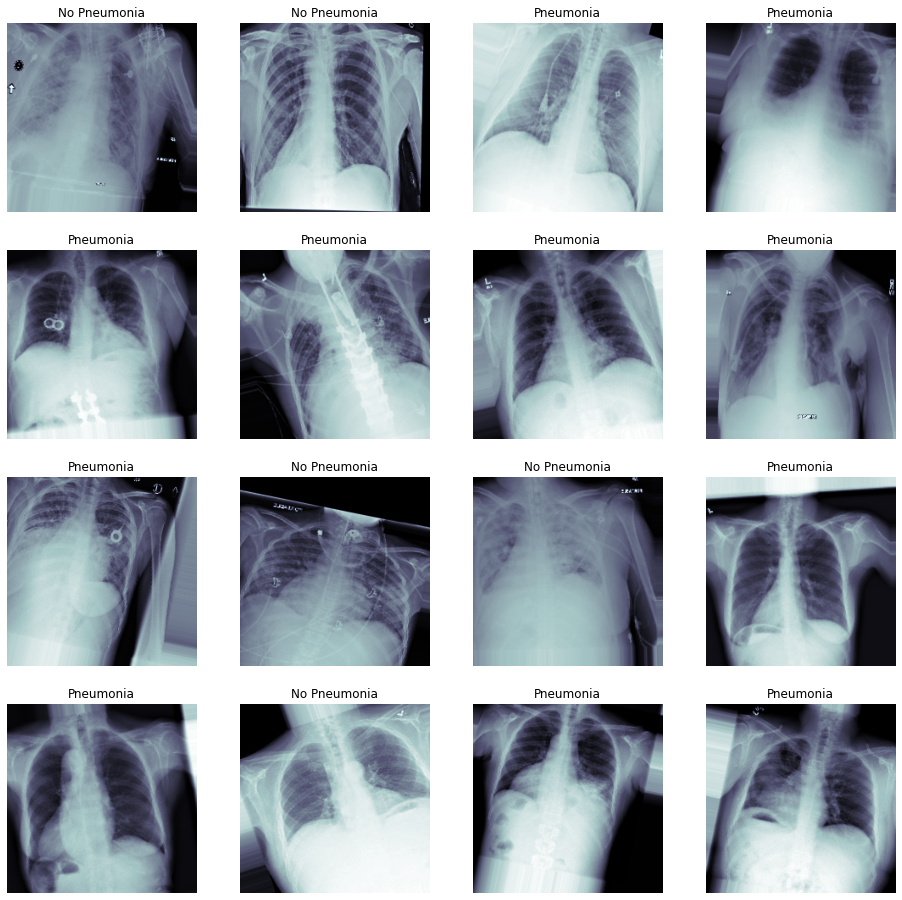

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

batch_size = 64
train_gen = train_generator(train_data, image_size, batch_size)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
def load_pretrained_model(pretrained_model, out_layer, top_layer=True):
    '''
    pretrained_model: pretrained modelto load
    out_layer: layer to output from pretrarined model
    top_layer: boolean to indicate if top layers are wanted
    '''
    
    # Define model
    model = pretrained_model(include_top=top_layer, weights='imagenet')
    # Choose layer to extract
    transfer_layer = model.get_layer(out_layer)
    vgg_model = Model(inputs=model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [14]:
def build_model(pretrained_model, out_layer, fine_tune_layer, dropout, \
                optimizer, loss, metrics, top_layer=True):
    '''
    pretrained_model: pretrained model to load
    out_layer: transfer layer to output from pretrarined model
    fine_tune_layer: layer of pretrained model fron which to fine-tune 
    dropout: ratio of weights to droptout during training
    optimizer: optimizer type
    loss: loss function
    metrics: metrics to moniyor
    top_layer: boolean to indicate if top layers are wanted
    '''
    # Load pretrained model
    pretrained_mod = load_pretrained_model(pretrained_model, out_layer, top_layer)
    # layers to fine-tune in pretrained model
    # freeze all layers except from layers indicated by user
    for layer in pretrained_mod.layers:
        if (layer.name == fine_tune_layer):
            break
            
        layer.trainable = False
    
    print("Transfer Model:")
    print("---------------")
    print(pretrained_mod.summary())
    print("Pretrained layers trainable status:")
    
    for layer in pretrained_mod.layers:
        print(layer.name, ":", layer.trainable)
    
    # Build model
    model = Sequential()
    # add pretrained model
    model.add(pretrained_mod) 
    # flatten output from pretrained model
    model.add(Flatten())
    model.add(Dropout(dropout))
    # add flat layers with dropout
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout))
    
    # Ouput layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    print("---------------")
    print("Final Model:")
    print("---------------")
    print(model.summary())
       
    return model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

monitor_metric = 'val_loss'
mode = 'min'
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= monitor_metric, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= mode, 
                             save_weights_only = True)

early = EarlyStopping(monitor= monitor_metric, 
                      mode= mode, 
                      patience=10)

callbacks_list = [checkpoint, early]

In [16]:
# Check GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

### Start training! 

In [17]:
## train your model

lr = 1e-4
pretrained_model = VGG16
out_layer = 'block5_pool'
fine_tune_layer = 'block5_conv3'
dropout = 0.25
optimizer = Adam(lr=lr)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
top_layer = True

model = build_model(pretrained_model, out_layer, fine_tune_layer, dropout, \
                    optimizer, loss, metrics, top_layer)

history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Transfer Model:
---------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D) 

36/36 [==============================] - 89s 2s/step - loss: 0.6539 - binary_accuracy: 0.6224 - val_loss: 0.7623 - val_binary_accuracy: 0.4187

Epoch 00014: val_loss did not improve from 0.53698
Epoch 15/100
36/36 [==============================] - 87s 2s/step - loss: 0.6513 - binary_accuracy: 0.6267 - val_loss: 0.7191 - val_binary_accuracy: 0.4885

Epoch 00015: val_loss did not improve from 0.53698
Epoch 16/100
36/36 [==============================] - 86s 2s/step - loss: 0.6476 - binary_accuracy: 0.6320 - val_loss: 0.5429 - val_binary_accuracy: 0.7584

Epoch 00016: val_loss did not improve from 0.53698
Epoch 17/100
36/36 [==============================] - 93s 3s/step - loss: 0.6451 - binary_accuracy: 0.6333 - val_loss: 0.5831 - val_binary_accuracy: 0.6860

Epoch 00017: val_loss did not improve from 0.53698
Epoch 18/100
36/36 [==============================] - 94s 3s/step - loss: 0.6380 - binary_accuracy: 0.6442 - val_loss: 0.6636 - val_binary_accuracy: 0.5790

Epoch 00018: val_loss di

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [18]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(weight_path)
# validate on a set that hasn't been seen by the model during training
valX, valY = val_gen.next()
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

6037/6037 [==============================] - 25s 4ms/step


In [87]:
def plot_auc(t_y, p_y):
    
    plt.figure(figsize=(8,8))
    plt.style.use("ggplot")
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = roc_auc_score(t_y, p_y)
    plt.plot(fpr, tpr, label="Pneumonia (AUC = %.2f)"%roc_auc)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("False positive rate", size=16)
    plt.ylabel("True positive rate", size=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.title("ROC curve", size=16)
    
    return

## what other performance statistics do you want to include here besides AUC? 

def plot_pr(t_y, p_y):

    plt.figure(figsize=(8,8))
    plt.style.use("ggplot")
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    AP = average_precision_score(t_y, p_y)
    plt.plot(recall, precision, label="Pneumonia (AP = {:.2f})".format(AP))
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("Recall", size=16)
    plt.ylabel("Precision", size=16)
    plt.title("Precision-Recall Curve", size=16)
    plt.legend(fontsize=16)
    
    return
# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    epochs = np.arange(len(history.history['loss']))
    plt.figure(figsize=(8,8))
    plt.style.use("ggplot")
    plt.plot(epochs, history.history['loss'], label="train_loss")
    plt.plot(epochs, history.history['val_loss'], label="val_loss")
      
    plt.plot(epochs, history.history['binary_accuracy'], label='train_accuracy')
    plt.plot(epochs, history.history['val_binary_accuracy'], label='val_accuracy')
    plt.title("Loss and Accuracy", size=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlabel("Epoch", size=16)
    plt.ylabel("Loss/Acuracy", size=16)
    plt.legend(fontsize=16)
    
    return

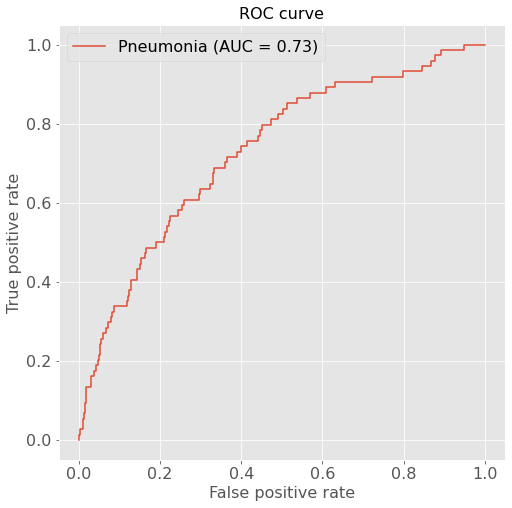

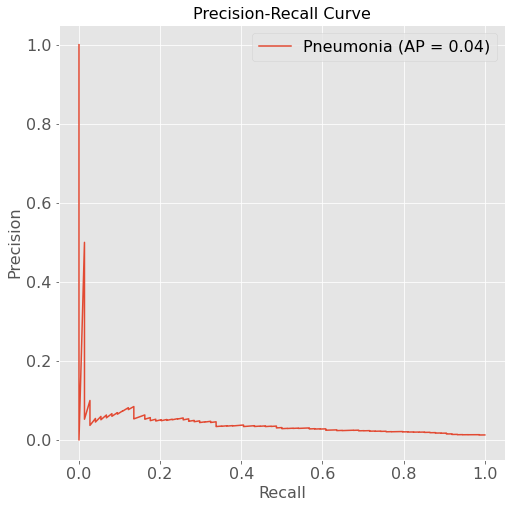

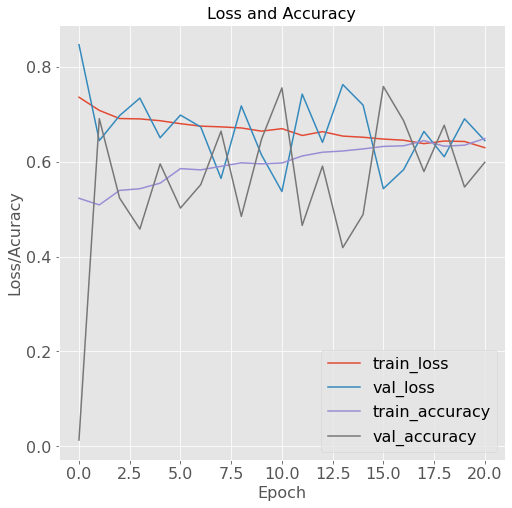

In [88]:
## plot figures

plot_auc(valY, pred_Y)
plot_pr(valY, pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)